In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, auc, roc_auc_score, roc_curve,  mean_squared_error
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.svm import SVC

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# %load "../preprocessing.py"
import matplotlib.pyplot as plt

def convert_object_to_numeric(data):
    for column in data.select_dtypes(include='object').columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

def plot_data(data):
    defects = data['defects'][data.defects == True].shape[0]
    non_defects = data['defects'][data.defects == False].shape[0]
    defect_count = [defects, non_defects]
    defect_label = ['defect', 'non_defects']
    plt.bar(defect_label, defect_count)
    for i, count in enumerate(defect_count):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()



def extract_and_eval(data):
    '''~
    input: data
    goal: make an evaluation to every sample and label
    '''
    eval = (data.n < 300) & (data.v < 1000) & (data.d < 50) & (data.e < 500000) & (data.t < 5000)
    data['eval'] = pd.DataFrame(eval)
    data['eval'] = [1 if e == True else 0 for e in data['eval']]

def evaluate(y_test, predictions, model):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(predictions, y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    metrics = {'Accuracy': accuracy,
               'Precision': precision,
               'Recall': recall,
               'FPR': fpr,
               'FNR': fnr,
               'AUC': auc}

    df = pd.DataFrame.from_dict(metrics, orient='index', columns=['value'])

    # Create a subplot within the figure and plot the evaluation results
    plt.subplot(1, 2, 1)
    sns.barplot(x=df.index, y='value', data=df)

    for i, v in enumerate(df['value']):
        plt.text(i, v + 0.01, str(round(v, 2)), ha='center')

    plt.title(f"{model.__class__.__name__}")
    plt.ylabel("Score")

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Create a subplot within the figure and plot the ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Label the plot
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)
    
    # Add labels to each cell
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.show()



def plot_evaluation(y_test, predictions, model):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the evaluation results in the first subplot
    plt.sca(axs[0])
    evaluate(y_test, predictions, model)

    # Plot the ROC curve in the second subplot
    plt.sca(axs[1])
    plot_confusion_matrix(y_test, predictions)

    # Show the figure
    plt.tight_layout()
    plt.show()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

def selectedtopfeatures(data, num_top_features=1):
    # Split-out validation dataset
    x = data.drop('defects', axis=1)
    y = data["defects"]

    # Get Training and Validation sets
    X_train, X_validation, Y_train, Y_validation = train_test_split(x, y, test_size=0.2, random_state=7)

    # Build a forest and compute the feature importances
    forest = RandomForestClassifier(n_estimators=250, random_state=0)
    forest.fit(X_train, Y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Let's grab the top features and their names
    top_features_indices = indices[:num_top_features]
    top_features = x.columns[top_features_indices]
    print("Top {} features:".format(num_top_features))
    print(top_features.tolist())

    # Use only the top features for cross-validation
    X_modified = X_train.iloc[:, top_features_indices]
    kfold = KFold(n_splits=6)
    cv = cross_val_score(forest, X_modified, Y_train, cv=kfold, scoring='accuracy')
    print("Cross-validation score using the top {} features: {:.4f}".format(num_top_features, cv.mean()))



x = 0
y = 0
def cvs(model, x=x, y=y, n=10):
    cv = RepeatedStratifiedKFold(n_splits=n, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return n_scores.mean()
    # Get Training and Validation sets
    # X_train, X_validation, Y_train, Y_validation = train_test_split(X_modified, y, test_size=0.2, random_state=7)

    # from sklearn.linear_model import LogisticRegressionCV
    # clf = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X_train, Y_train)
    # predictions = clf.predict(X_validation)
    # return accuracy_score(Y_validation, predictions)

In [3]:
# data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Software Defect/JM1/jm1.csv")
data = pd.read_csv("../archive/jm1.csv")

In [75]:
data.shape

(10880, 22)

In [34]:
cols = data.columns
cols

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

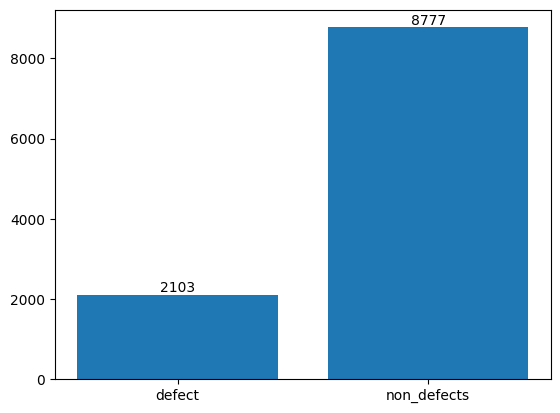

In [40]:
plot_data(data)

In [36]:
# extract_and_eval(data)

In [13]:
data = convert_object_to_numeric(data)
data = data.dropna()
data = data.reset_index(drop=True)

In [14]:
data.shape

(10880, 22)

In [80]:
x = pd.DataFrame(data.drop('defects', axis=1))
# y = pd.DataFrame(data["defects"])
# x = pd.DataFrame(data[features]).drop('defects', axis=1)
y = pd.DataFrame(data["defects"])

In [85]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)
x, y = ros.fit_resample(x.values, y)
data_scaled = pd.DataFrame(x)
# data_scaled.columns = cols[:-1]
# data_scaled.columns = features[:-1]
data_scaled['defects'] = y

In [86]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

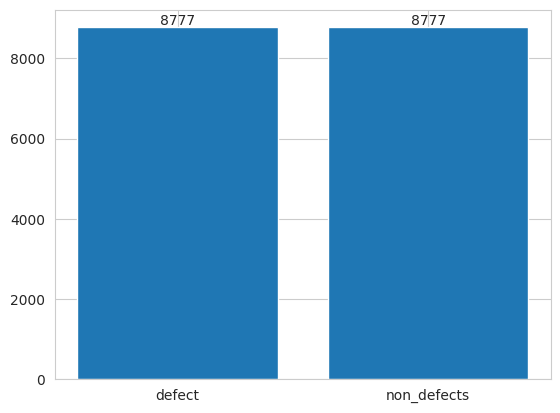

In [87]:
plot_data(data_scaled)

In [88]:
"""
Split the data train & data test & also the data validation
"""
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, test_size=0.3, random_state=1
)
# x_train, x_test, y_train, y_test = train_test_split(
#     x_scaled, y_scaled, test_size=0.2, random_state=1
# )

In [89]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
x_train_ = scaler.fit_transform(x_train)
x_test_ = scaler.transform(x_test)

In [90]:
x_scaled_ = scaler.fit_transform(x)

### Logistic Regression

In [91]:
model = LogisticRegression()
model.fit(x_train_, y_train)
predictions = model.predict(x_test_)

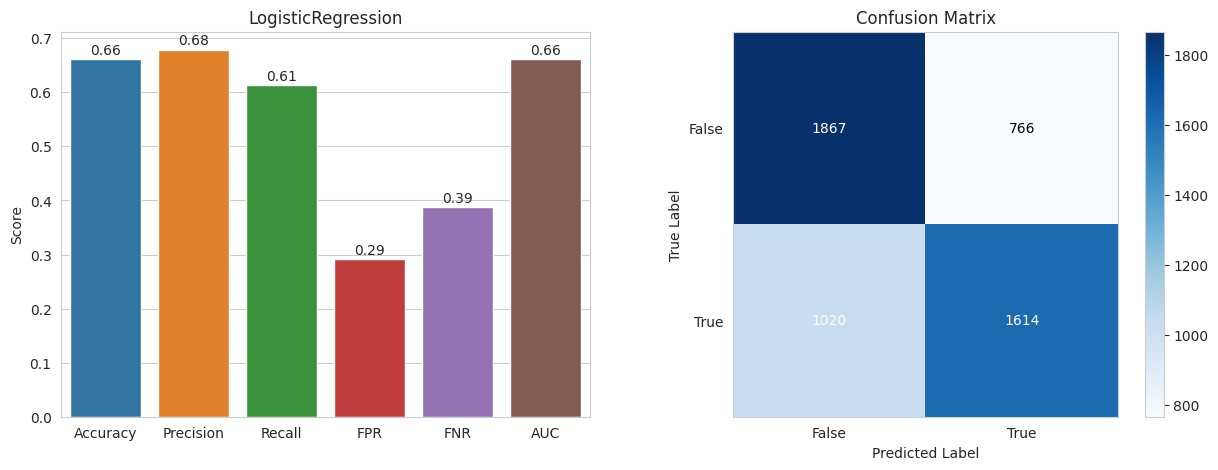

<Figure size 640x480 with 0 Axes>

In [92]:
plot_evaluation(y_test, predictions, model)

### Decision Tree

In [93]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train_, y_train)
predictions = tree.predict(x_test_)

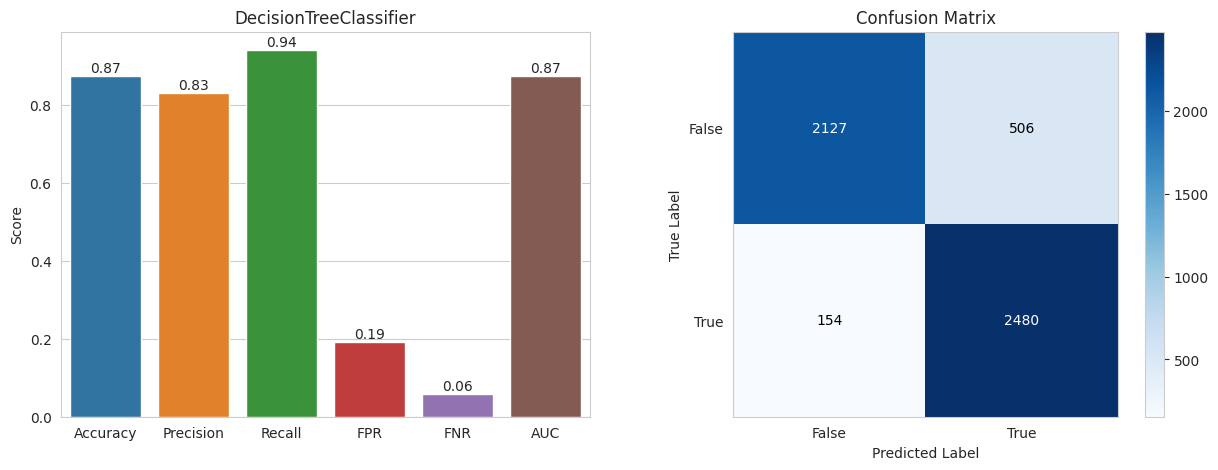

<Figure size 640x480 with 0 Axes>

In [94]:
plot_evaluation(y_test, predictions, tree)

### XGBoost

In [95]:
xgb = XGBClassifier(
    max_depth=11,
    learning_rate=0.01,
    n_estimators=300,
    reg_alpha=1.1,
    colsample_bytree = 0.9,
    subsample = 0.9,
    n_jobs = 5
)

In [96]:
xgb.fit(x_train_, y_train, eval_set=[(x_test_, y_test)], verbose=False, early_stopping_rounds=2)
# pred
pred = xgb.predict(x_test_)

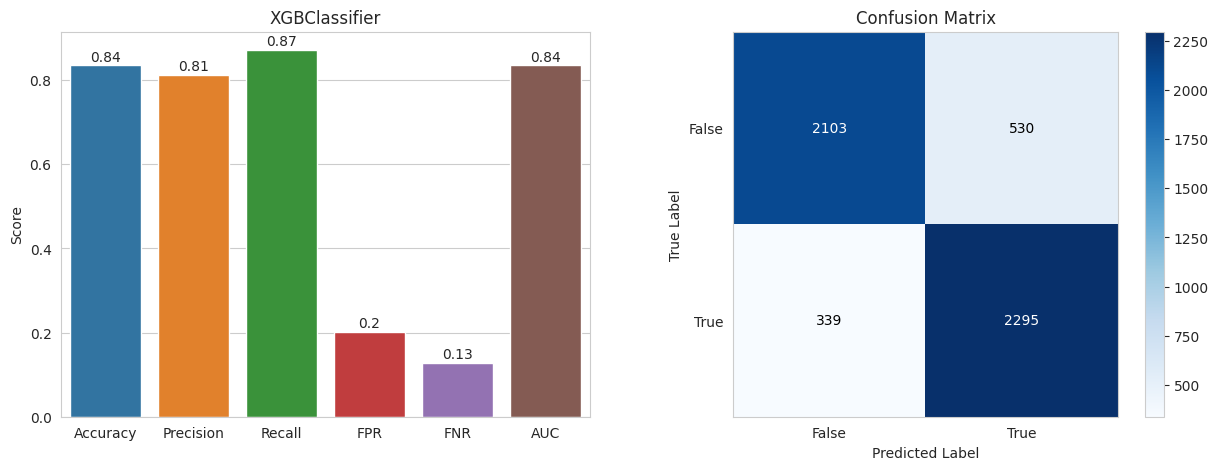

<Figure size 640x480 with 0 Axes>

In [97]:
plot_evaluation(y_test, pred, xgb)

### Random Forest

In [98]:
randomforest = RandomForestClassifier()
randomforest.fit(x_train_, y_train)

RandomForestClassifier()

CPU times: user 0 ns, sys: 76 µs, total: 76 µs
Wall time: 263 µs


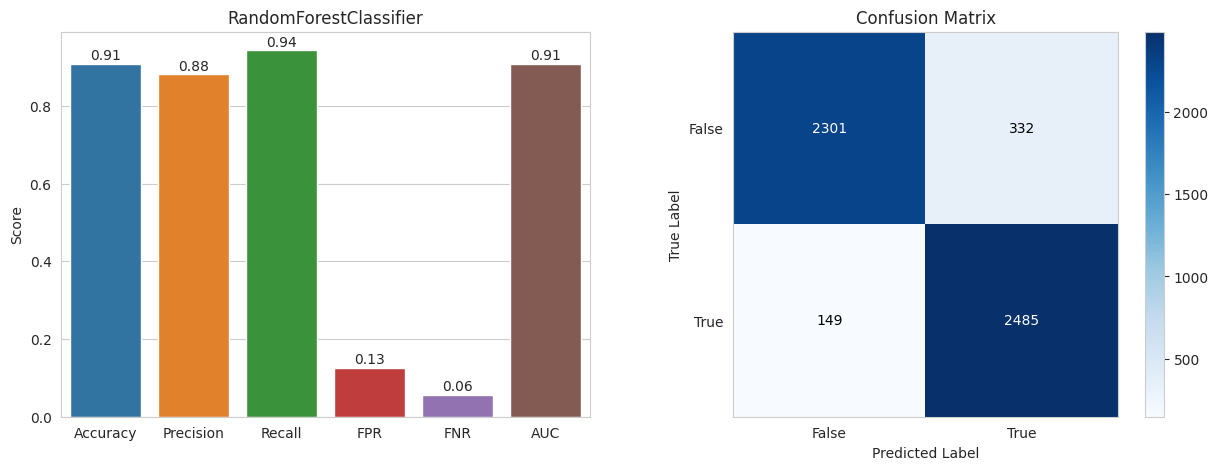

<Figure size 640x480 with 0 Axes>

In [99]:
%time
plot_evaluation(y_test, randomforest.predict(x_test_), randomforest)

### Ada Boost

In [100]:
ada = AdaBoostClassifier(learning_rate=0.1, n_estimators=300)
ada.fit(x_train_, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=300)

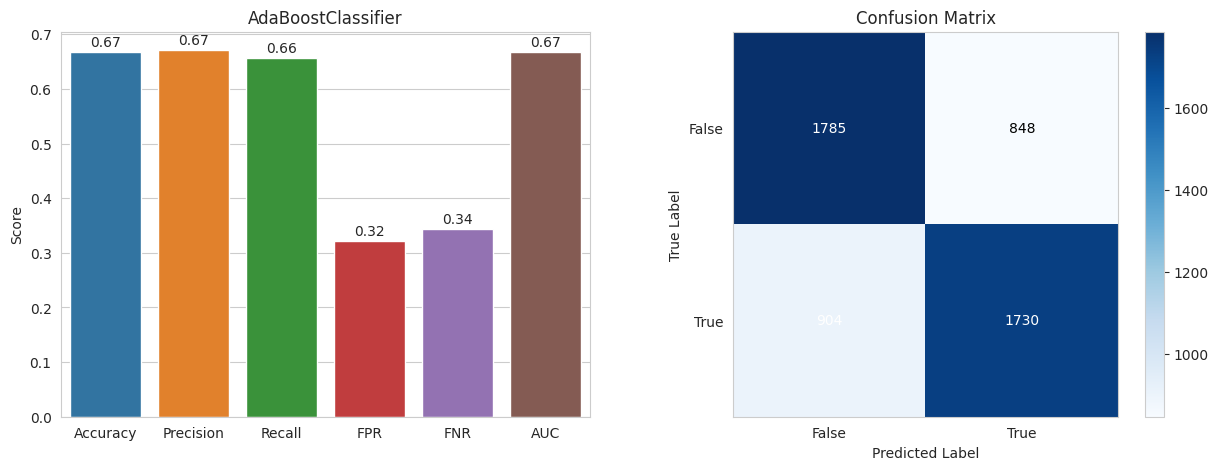

<Figure size 640x480 with 0 Axes>

In [101]:
plot_evaluation(y_test, ada.predict(x_test_), ada)

### Gradient Boost

In [102]:
gradient = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300, min_samples_split=3, min_samples_leaf=1,verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, tol=0.0001, ccp_alpha=0.0)
gradient.fit(x_train_, y_train)

GradientBoostingClassifier(min_samples_split=3, n_estimators=300)

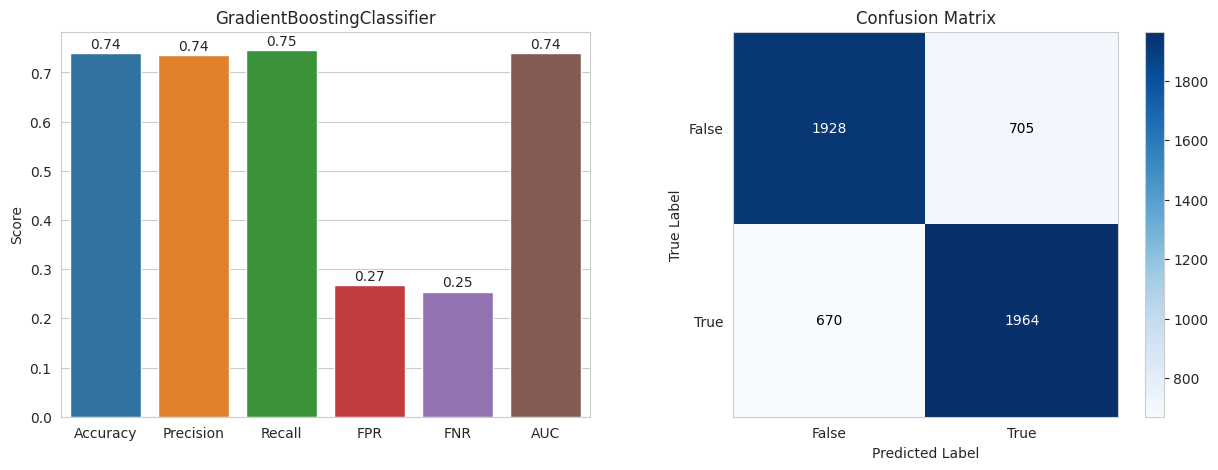

<Figure size 640x480 with 0 Axes>

In [103]:
plot_evaluation(y_test, gradient.predict(x_test_), gradient)

### Bagging Classifier

In [104]:
bag = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=10)
bag.fit(x_train_, y_train)

BaggingClassifier(estimator=RandomForestClassifier())

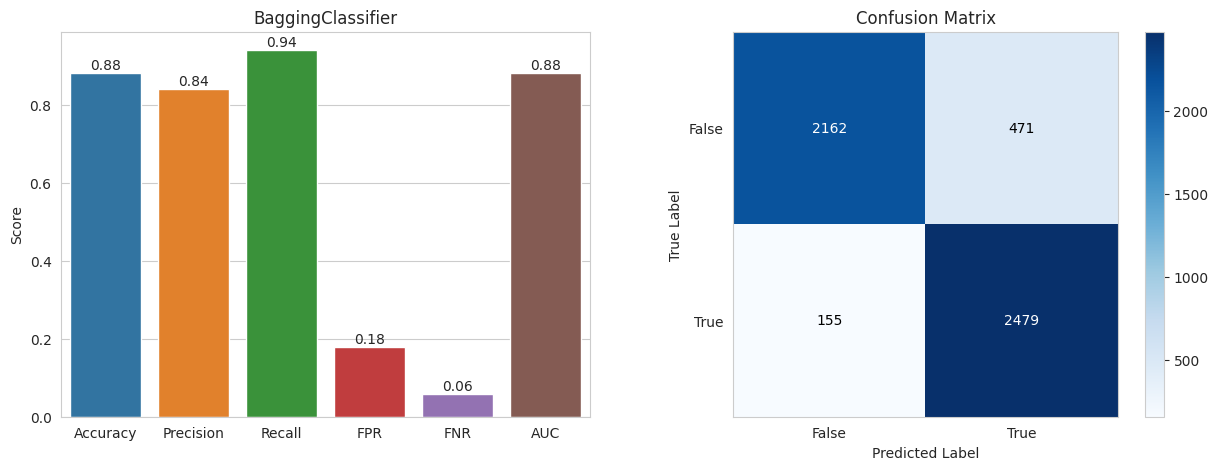

<Figure size 640x480 with 0 Axes>

In [105]:
plot_evaluation(y_test, bag.predict(x_test_), bag)

### Voting Classifier

In [106]:
voting = VotingClassifier(
     estimators=[('xgb', xgb), ('rf', randomforest), ('bag', bag)],
     voting='soft')

In [107]:
voting.fit(x_train_, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=11,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=300, n_jobs=5,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('rf', RandomForestClassifier()),
                             ('bag',
                              BaggingClassifier(estimator=RandomForestClassifier()))],
                 voting='soft')

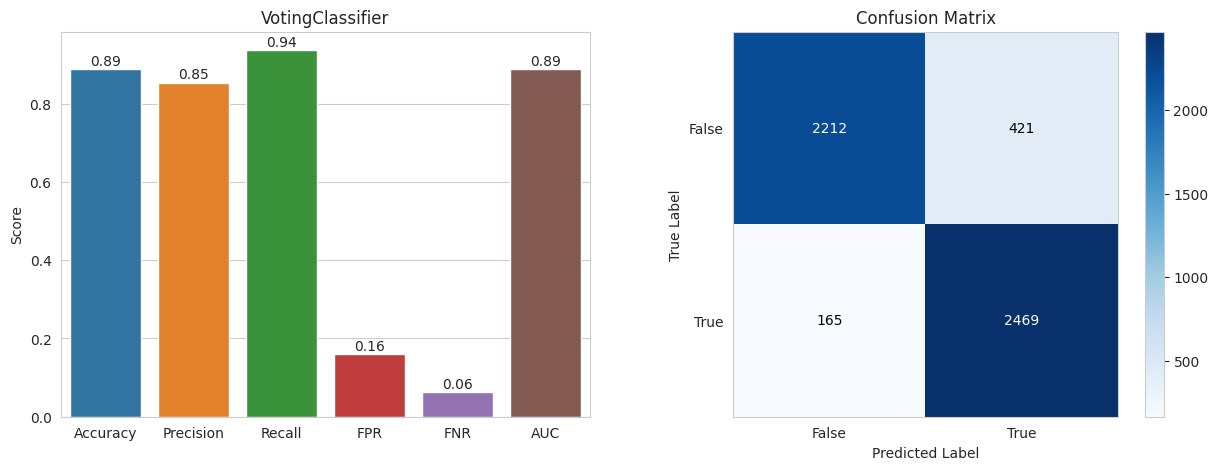

<Figure size 640x480 with 0 Axes>

In [108]:
plot_evaluation(y_test, voting.predict(x_test_), voting)

### Nearest Neighbors

In [109]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
knn.fit(x_train_, y_train)
pred = knn.predict(x_test_)

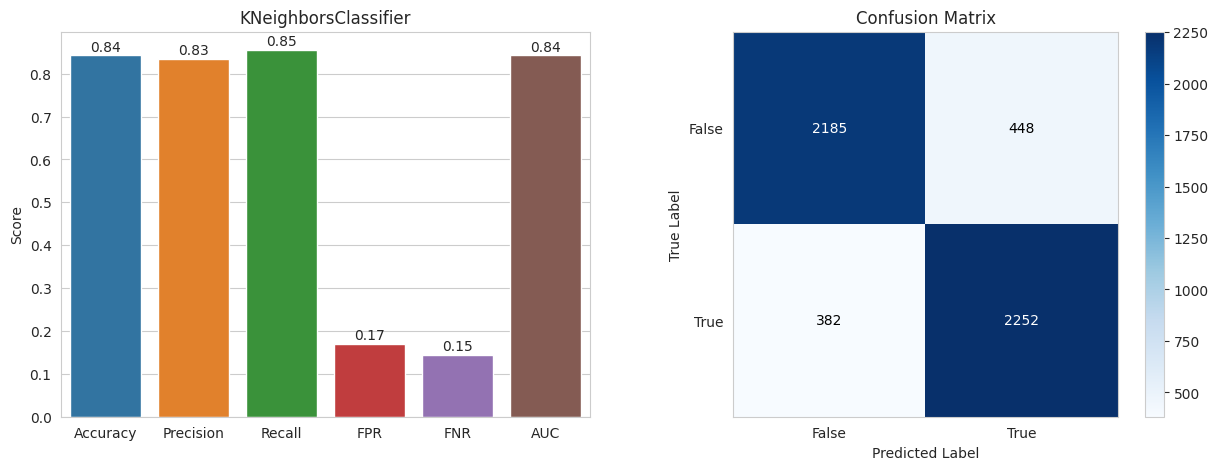

<Figure size 640x480 with 0 Axes>

In [110]:
plot_evaluation(y_test, pred, knn)

### SVC

In [111]:
svc = SVC(C=2)
svc.fit(x_train_, y_train)
pred = svc.predict(x_test_)

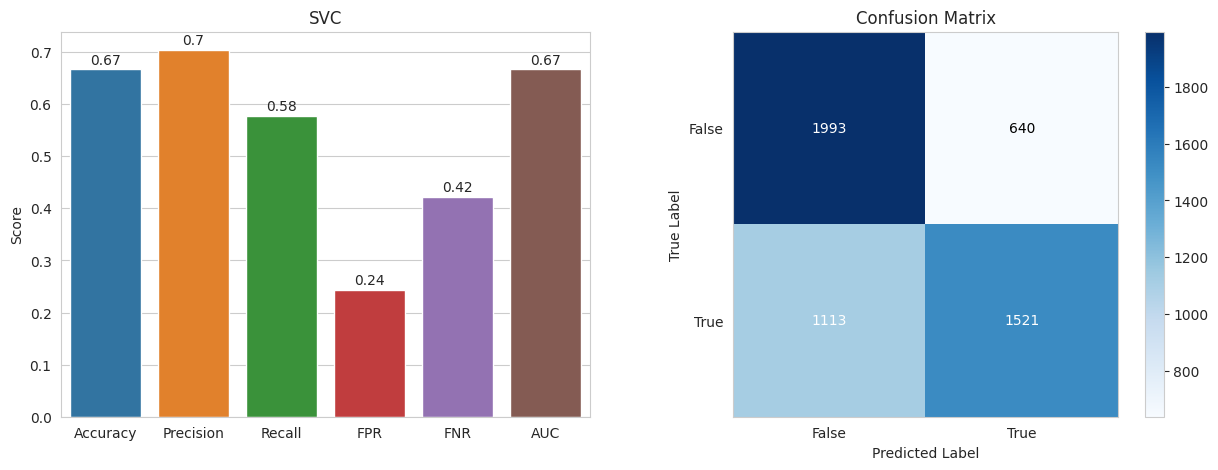

<Figure size 640x480 with 0 Axes>

In [112]:
plot_evaluation(y_test, svc.predict(x_test_), svc)

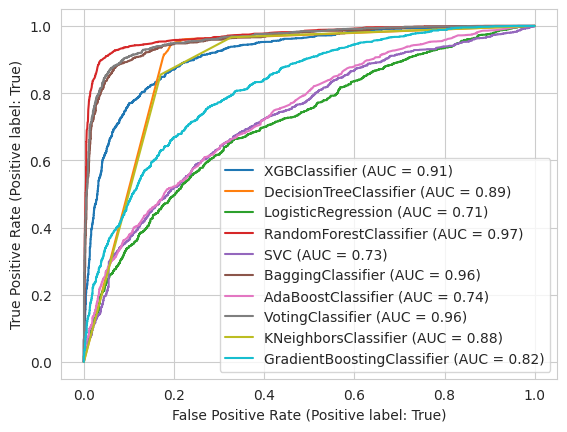

In [113]:
ROC_curve = RocCurveDisplay.from_estimator(xgb, x_test_, y_test)
ROC_curve = RocCurveDisplay.from_estimator(tree, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(model, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(randomforest, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(svc, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(bag, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(ada, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(voting, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(knn, x_test_, y_test, ax=ROC_curve.ax_)
ROC_curve = RocCurveDisplay.from_estimator(gradient, x_test_, y_test, ax=ROC_curve.ax_)


In [68]:
logistic_score = cvs(model, x, y)
gradient_score = cvs(gradient, x, y)
ada_score = cvs(ada, x, y)
bag_score = cvs(bag, x, y)
tree_score = cvs(tree, x, y)
randomforest_score = cvs(randomforest, x, y)
knn_score = cvs(knn, x, y)
svc_score = cvs(svc, x, y)
voting_score = cvs(voting, x, y)
xgb_score = cvs(xgb, x, y)

/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/anonymous/envs/langchain/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when 

In [69]:
scores = [
    logistic_score,
    gradient_score,
    ada_score,
    bag_score,
    tree_score,
    randomforest_score,
    knn_score,
    svc_score,
    voting_score,
    xgb_score
]
labels = [
    'Logistic',
    'Gradient',
    'Ada',
    'Bag',
    'Tree',
    'Randomforest',
    'KNN',
    'SVC',
    'Voting',
    'XGB'
]

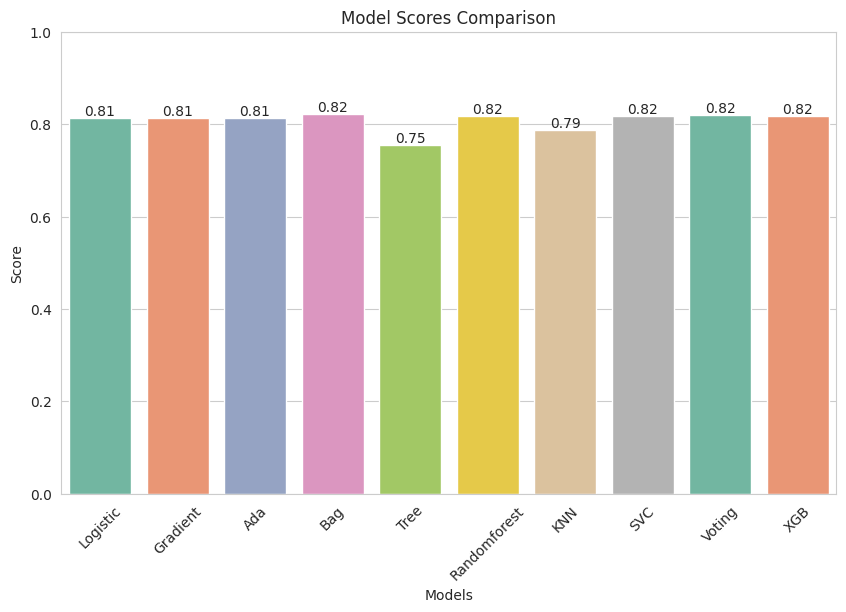

In [70]:
scores_df = pd.DataFrame({'Models': labels, 'Scores': scores})

sns.set_style('whitegrid')

# Plot the grouped bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Models', y='Scores', data=scores_df, palette='Set2')

# Add the scores as text above the bars
for index, value in enumerate(scores):
    ax.text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Scores Comparison')
plt.ylim(0, 1)  # Limit the y-axis to a maximum of 1
plt.xticks(rotation=45)
plt.show()

In [8]:
def handle_outliers(data, column_name, lower_bound=None, upper_bound=None):
    if lower_bound is None and upper_bound is None:
        # Calculate the Interquartile Range (IQR)
        Q1 = data[column_name].quantile(0.25)
        Q3 = data[column_name].quantile(0.75)
        IQR = Q3 - Q1

        # Set the lower and upper bounds for outlier detection
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]

    # Treat outliers by capping their values to the lower and upper bounds
    data_treated = data.copy()
    data_treated[column_name] = data_treated[column_name].clip(lower=lower_bound, upper=upper_bound)


    return data_treated, outliers

In [13]:
data_, outliers = handle_outliers(data, 'v')

In [10]:
data_.shape

(10885, 22)

In [44]:
data = data_

In [11]:
data['loc'] = np.log(data["loc"])

In [4]:

def plot_features_vs_target(data, features, target_variable):
    num_plots = len(features)
    num_cols = 3  # Set the number of columns in the grid

    num_rows = (num_plots - 1) // num_cols + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].scatter(data[feature], data[target_variable], c=data[target_variable], cmap='viridis')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel(target_variable)
        axes[row, col].set_title(f"{feature} vs. {target_variable}")
        axes[row, col].grid(True)

    # Remove any empty subplots
    for i in range(num_plots, num_cols*num_rows):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data_' is your DataFrame and 'defects' is the target variable


In [6]:
features = ['loc', 'i', 'v', 'lOCode', 'e', 't', 'iv(g)', 'd', 'branchCount', 'total_Op', 'v(g)', 'lOBlank', 'n', 'uniq_Opnd']

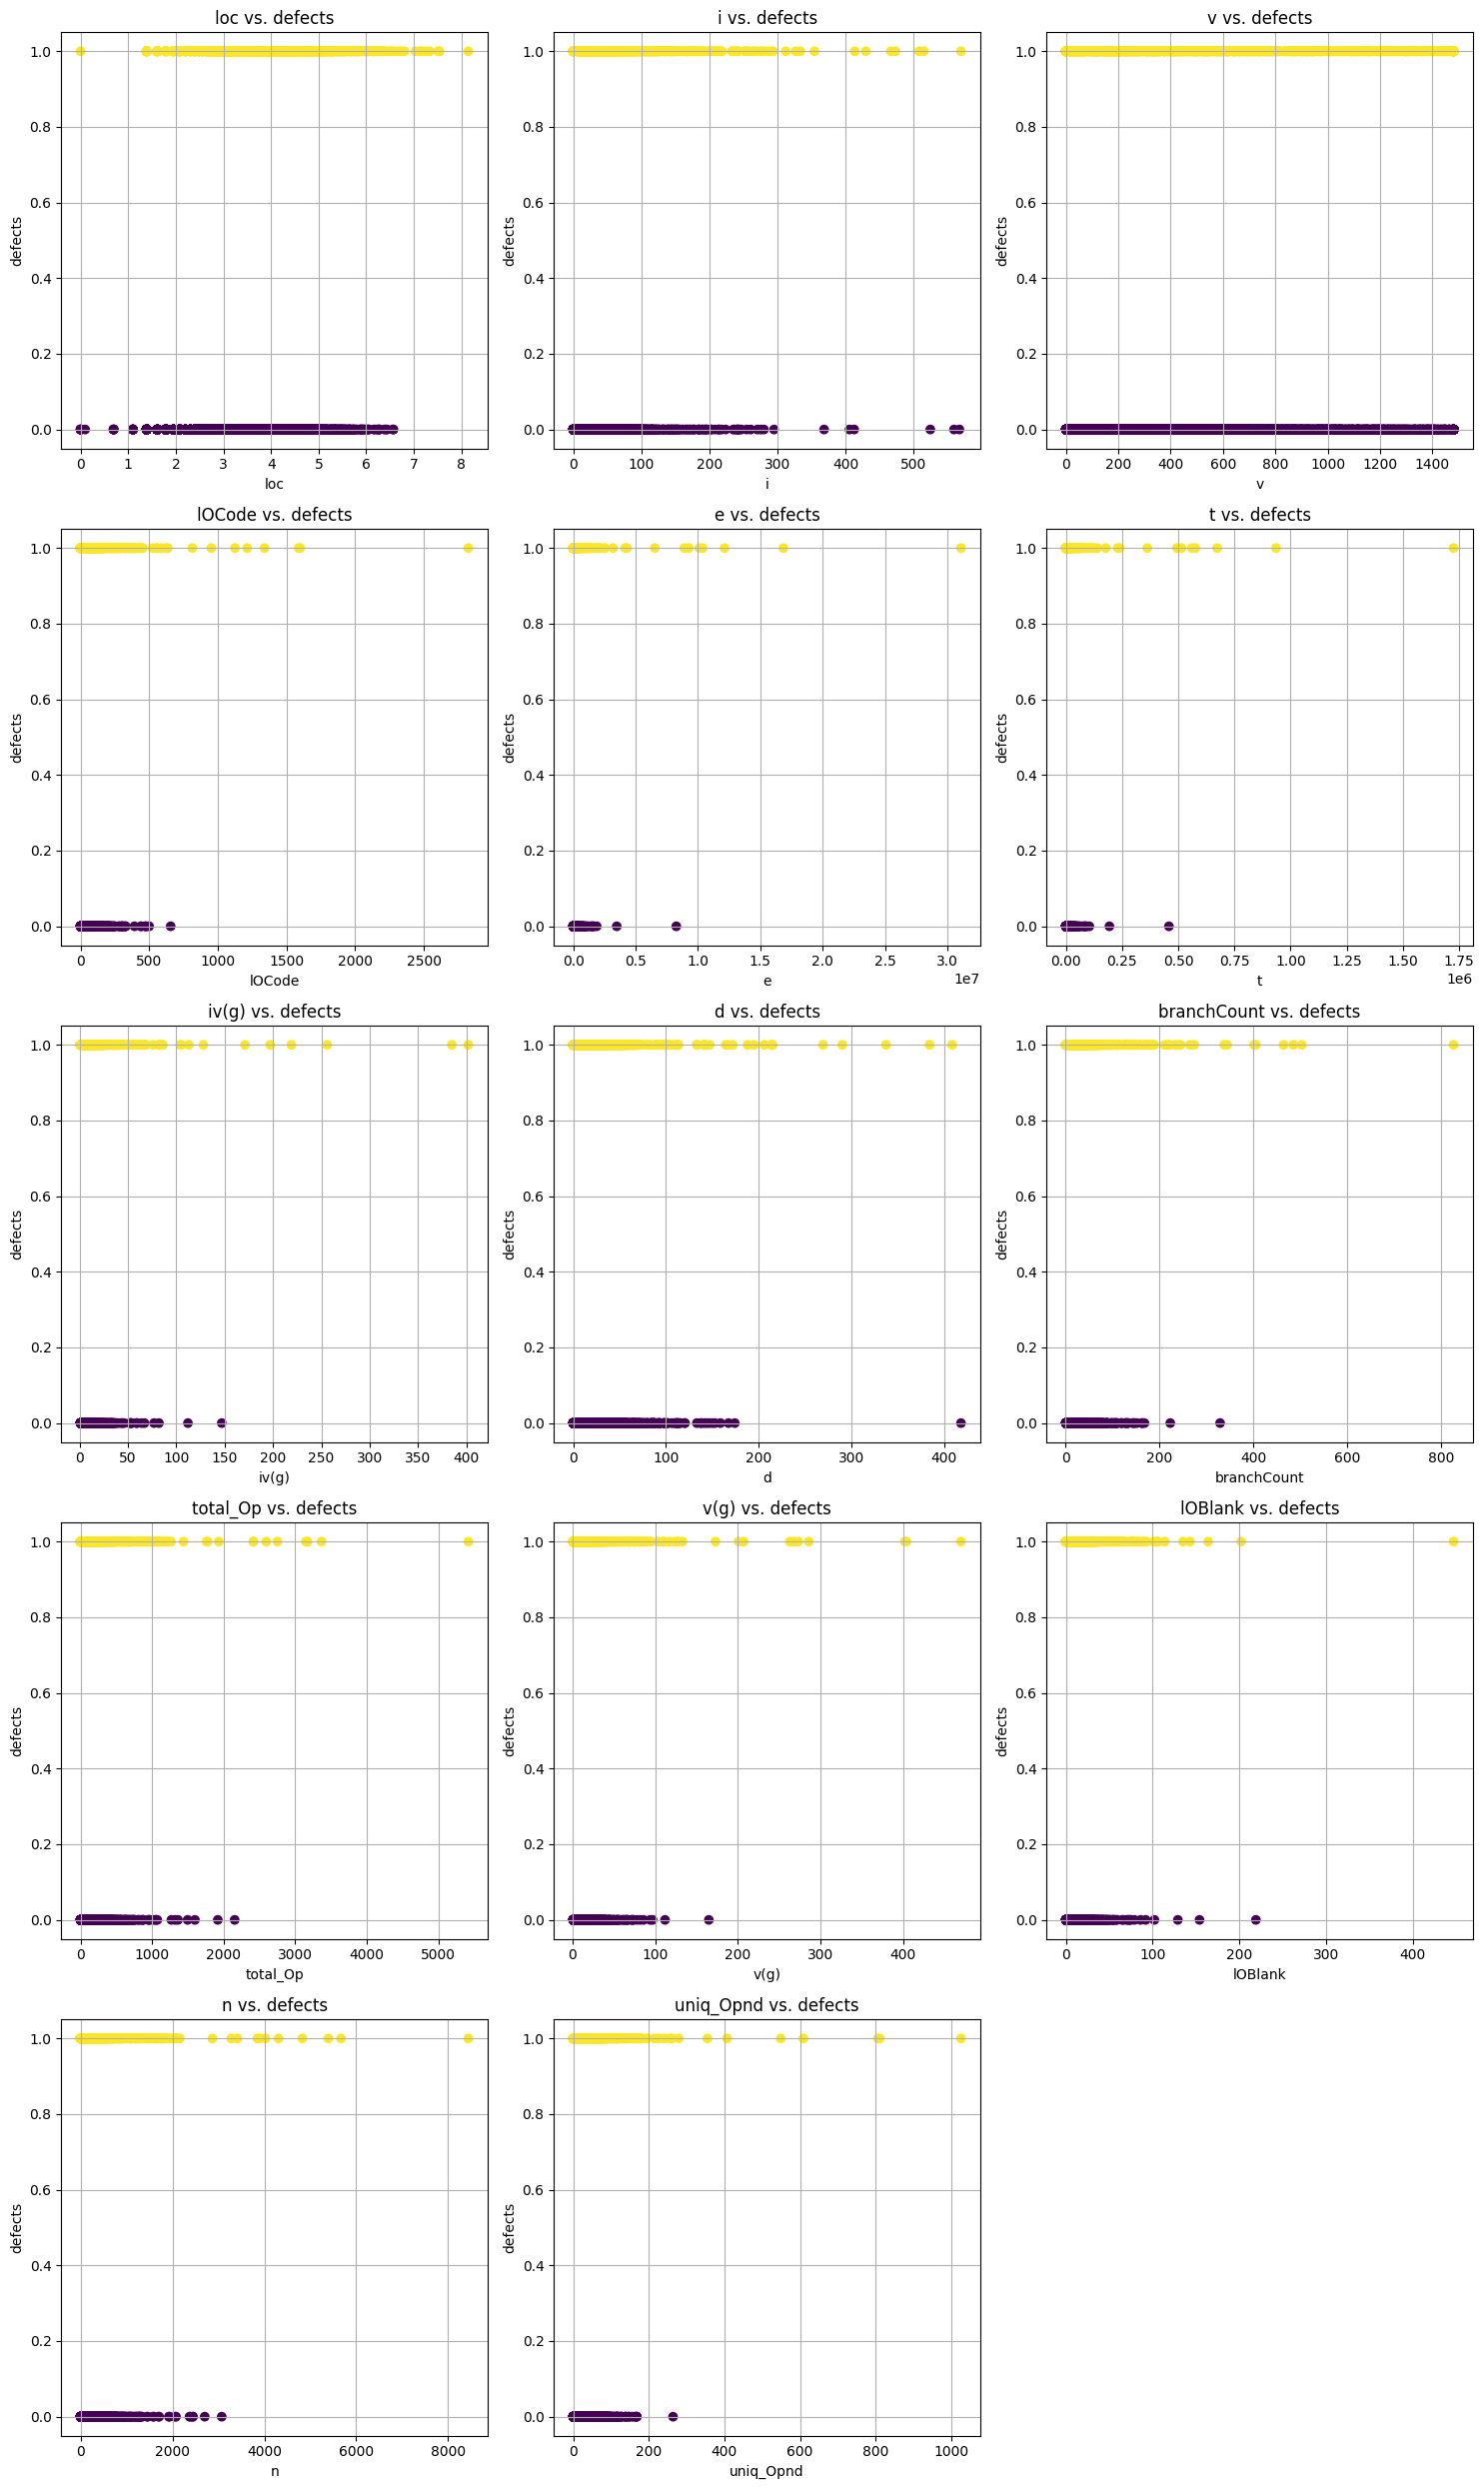

In [52]:
plot_features_vs_target(data_, features, 'defects')

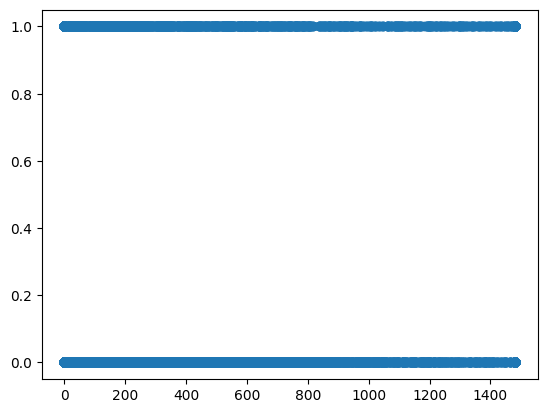

In [54]:
# 'branchCount', 'total_Op', 'v(g)', 'lOBlank', 'n', 'uniq_Opnd', 'total_Opnd'
plt.scatter(data_['v'], data_['defects'])

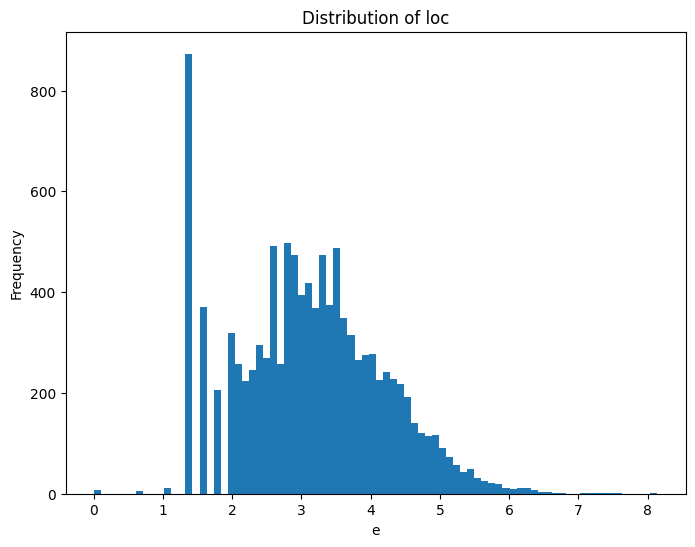

In [60]:
plt.figure(figsize=(8, 6))
plt.hist(data['loc'], bins=80)
plt.xlabel('e')
plt.ylabel('Frequency')
plt.title('Distribution of loc')
plt.show()

In [96]:
data['complexity_interaction'] = data['v(g)'] * data['n']

In [97]:
data['efficiency_ratio'] = data['v'] / data['e']

In [98]:
data['complexity_diff'] = data['iv(g)'] - data['v(g)']

In [100]:
data['complexity_to_length_ratio'] = data['v(g)'] / data['l']

In [73]:
import pickle

In [71]:
dataset = {
    'data': data,
    'models': {
        'logistic': model,
        'gradient': gradient,
        'ada': ada,
        'bag': bag,
        'tree': tree,
        'randomforest': randomforest,
        'knn': knn,
        'svc': svc,
        'voting': voting,
        'xgb': xgb
    },
    'scores': scores,
    'labels': labels,
    'x': x,
    'y': y,
    'x_train': x_train_,
    'x_test': x_test_,
    'y_train': y_train,
    'y_test': y_test
}

In [74]:
file = '../jm1I.pkl'

# Save the models dictionary to the pickle file
with open(file, 'wb') as file:
    pickle.dump(dataset, file)

In [101]:
import seaborn as sns